# (12)

...

In [3]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [4]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [349]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
conc_sep_all_lins = [];
for i in 1:length(fluor_sep_all_lins)
    num_i = fluor_sep_all_lins[i]./fpm;
    conc_i = [num_i[y] ./ vol_sep_all_lins[i][y] for y in 1:length(vol_sep_all_lins[i])];
    push!(num_sep_all_lins,num_i);
    push!(conc_sep_all_lins,conc_i);
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

Now, let's plot all the generation concentration trajectories for the first lineage.

In [350]:
using Plots, Statistics, StatsBase, Distances, Distributions, GpABC, LaTeXStrings, LinearAlgebra; pyplot();

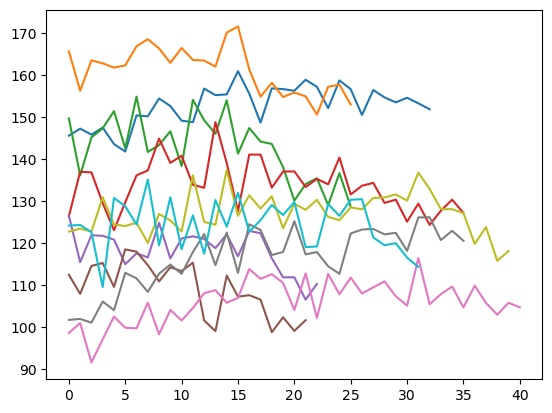

In [800]:
e_gen = 1;
conc_gens = deepcopy(conc_sep_all_lins[e_gen]);
fig, ax = PyPlot.subplots(1,1);
for i in 1:10#length(conc_gens)
    ax.plot(conc_gens[i])
end
PyPlot.show()

Need to make all generation arrays the same length if I am to convert the `conc_gens` `Array{Array{Float64,1}}` to a `Array{Float64,2}` array.

In [801]:
# find the longest generation
max_len = maximum([length(gen) for gen in conc_gens]);
[length(gen) for gen in conc_gens];

In [802]:
norm_gens_temp = []; # new conc gens array with added NaNs to make all the same length.
for gen in conc_gens
    gen_len = length(gen)
    new_gen = copy(gen)
    add_nans = [NaN for i in 1:(max_len-gen_len)]
    append!(new_gen, add_nans)
    push!(norm_gens_temp, new_gen)
end

In [803]:
norm_gens = convert(Array{Float64,2},transpose(hcat(norm_gens_temp...)));

In [804]:
norm_gens[1,:]; # gives the first lineage.
norm_gens[:,1]; # gives first timepts.
print(mean(filter(!isnan, norm_gens[1,:])),"\n") # removes the NaNs
print(mean(norm_gens[1,:])) # does not remove NaNs

152.60454608379806
NaN

Let's produce some histograms over the data.

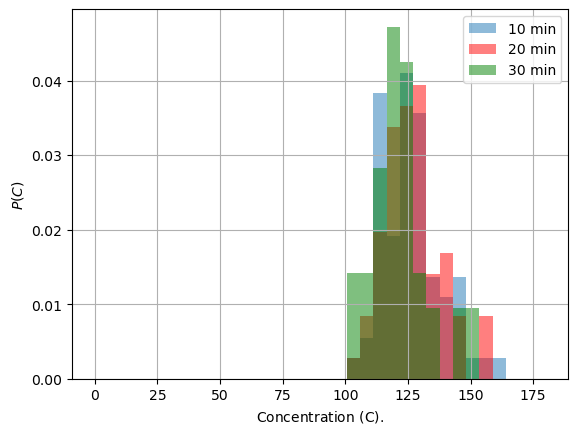

In [805]:
fig, ax = PyPlot.subplots(1,1);
time_bins = LinRange(0.0, 180.0, 35);
hist1, os = ax.hist(norm_gens[:,10], bins = time_bins, density = true, alpha = 0.5, label = "10 min"); 
hist2, os = ax.hist(norm_gens[:,20], color = "r", bins = time_bins, density = true, alpha = 0.5, label = "20 min"); 
hist3, os = ax.hist(norm_gens[:,30], color = "g", bins = time_bins, density = true, alpha = 0.5, label = "30 min"); 
ax.grid(true); ax.set_xlabel(L"Concentration (C)$.$"); ax.set_ylabel(L"$P(C)$"); ax.legend()
PyPlot.show()

In [806]:
@time hellinger(hist1, hist2)

  0.000005 seconds (1 allocation: 16 bytes)


0.19249873296605996

# Calculate $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ from Lsq on the mean for each generation

In [807]:
using LsqFit;

In [808]:
v0_n0_th[e_gen][1][3]

0.025377210406455762

In [809]:
LinRange(1,length(conc_gens[1]), length(conc_gens[1]))

33-element LinRange{Float64}:
 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,…,27.0,28.0,29.0,30.0,31.0,32.0,33.0

In [810]:
comb_pars = [];
for i in 1:length(v0_n0_th[e_gen])
    v0 = v0_n0_th[e_gen][i][1]; n0 = v0_n0_th[e_gen][i][2]; th = v0_n0_th[e_gen][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((10 .^ab[1]*v0^(10 .^ab[2]-1))/(10 .^ab[2]*th))*(exp.((10 .^ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t);
    ab0 = [-1.0, 0.0];
    c_data = conc_gens[i];
    fit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars,fit)
end
comb_pars = convert(Array{Float64,2},transpose(hcat(comb_pars...)))

69×2 Array{Float64,2}:
  5.54741  0.745866
  8.02481  0.357899
  7.71658  0.278743
  8.84573  0.298974
  3.33371  0.928663
  6.55456  3.36534e-12
  3.77706  0.633656
  4.94288  0.575325
  4.50693  0.635045
  4.71304  0.644029
  8.77044  0.112751
  3.53907  0.967284
  6.28843  0.403306
  ⋮        
  6.63617  0.255345
 10.251    3.87374e-7
  6.59663  0.250774
  8.6893   2.3486e-13
  2.9278   1.16107
  7.15609  0.159103
  6.28589  0.45608
  3.72728  0.837923
  8.46323  1.14757e-8
  3.88992  0.713804
  7.81033  0.364115
  7.87698  0.304091

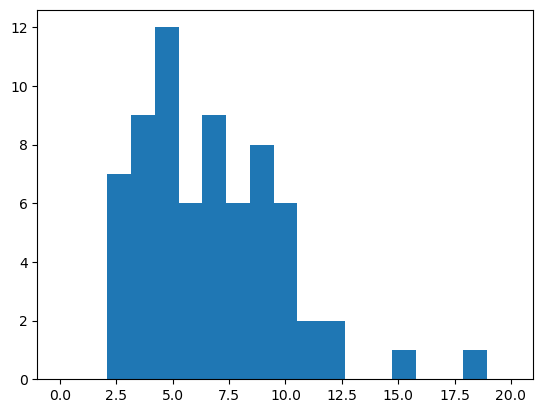

In [815]:
PyPlot.hist(comb_pars[:,1], bins = LinRange(0.0, 20, 20));

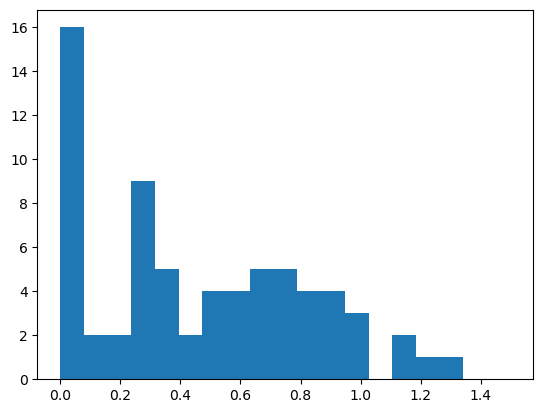

In [811]:
PyPlot.hist(comb_pars[:,2], bins = LinRange(0.0, 1.5, 20));

**Interesting that this same peak at zero (seen in all the experimental data) is recovered in the expt SSA with large burst sizes. Rather than fitting choosing $\alpha_0 \beta_0$ and $\alpha_1 +\beta_1$ to the means of these distributions we would undergo another ABC procedure to match the distributions of the experimental LSQ fitting to the SSA. This could allow for full determination of parameters in the stochastic model. Distance function would be the product of the HD of each histogram compared to the experimental data.**

**This possibly makes sense since if the burst size is volume dependent only some experimental runs will be subjegated to the stochasticity of the burst size unlike the more deterministic increase in molecule over every trajectory seen when the transcription rate is volume dependent.**

**Highly indicative of burst size dependency on volume.**

In [500]:
av_ab_0 = sum(comb_pars[:,1])/length(comb_pars[:,1]); av_ab_1 = sum(comb_pars[:,2])/length(comb_pars[:,2]);
print(av_ab_0, "\t", av_ab_1, "\t")

6.729567088902437	0.4606938536720015	

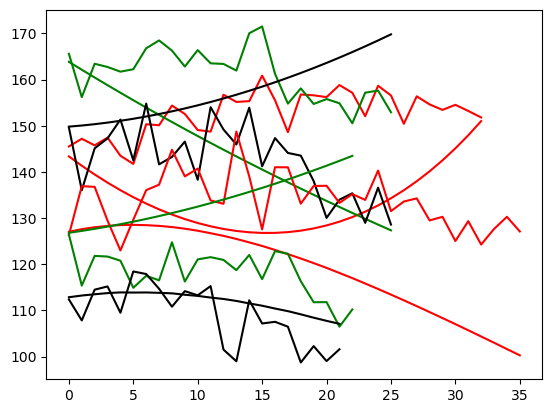

In [848]:
avg_traj = [];
for i in 1:10
    v0 = v0_n0_th[e_gen][i][1]; n0 = v0_n0_th[e_gen][i][2]; th = v0_n0_th[e_gen][i][3];
    c_0 = n0/v0; #ab = [av_ab_0, av_ab_1];
    ab = comb_pars[i,:];
    traj = [((ab[1]*v0^(ab[2]-1))/(ab[2]*th))*(exp.((ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t) for t in 1:length(conc_gens[i])];
    push!(avg_traj,traj)
end

#print(avg_traj[1]);
colors = ["r","g","black","r","g","black","r","g","black"];
fig, ax = PyPlot.subplots(1,1);
for i in 1:6#length(conc_gens)
    ax.plot(conc_gens[i], color = colors[i])
    ax.plot(avg_traj[i], color = colors[i])
end
PyPlot.show()

# Artificial data: transcription rate dependence on volume.

Now let's do the same for some artificial data.

In [840]:
true_par = [0.1,1E-6,0.5,0.8]; # one can see below that switching the volume dependency leads to much worse concentration histograms.

In [841]:
lineage_data = conc_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data::Array{Array{Float64,1},1}, inf_par::Array{Float64,1}, ics::Array{Any,1}) # arguments are wrt each lineage.
    SSA_data_c = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        push!(SSA_data_c, ssa[2][:]);
    end
    return vcat(SSA_data_c)# return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [842]:
expt_ssa_conc = Single_lin(conc_gens, true_par, v0_n0_th[1]);

In [824]:
lineage_data;

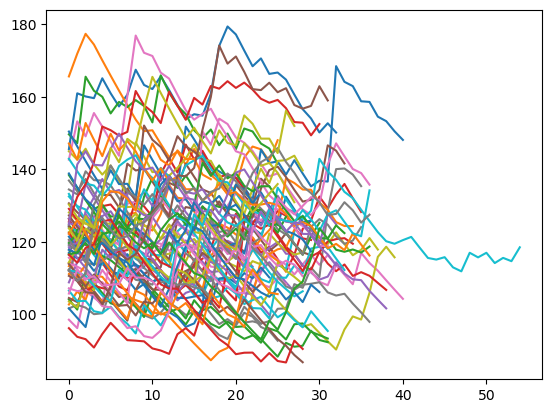

In [825]:
conc_gens_art = deepcopy(expt_ssa_conc);
fig, ax = PyPlot.subplots(1,1);
for i in 1:length(conc_gens)
    ax.plot(conc_gens_art[i])
end
PyPlot.show()

Need to make all generation arrays the same length if I am to convert the `conc_gens` `Array{Array{Float64,1}}` to a `Array{Float64,2}` array.

In [826]:
# find the longest generation
max_len_art = maximum([length(gen) for gen in conc_gens_art])

55

In [827]:
norm_gens_temp_art = []; # new conc gens array with added NaNs to make all the same length.
for gen in conc_gens_art
    gen_len = length(gen)
    new_gen_art = gen
    add_nans = [NaN for i in 1:(max_len_art-gen_len)]
    append!(new_gen_art, add_nans)
    push!(norm_gens_temp_art, new_gen_art)
end

In [828]:
norm_gens_art = convert(Array{Float64,2},transpose(hcat(norm_gens_temp_art...)))

69×55 Array{Float64,2}:
 145.52   160.935   160.075   159.599  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 165.588  171.857   177.335   174.38      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 149.631  147.196   165.513   161.642     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 126.334  122.69    119.152   117.566     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 126.443  124.671   122.892   122.64      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 112.391  109.604   107.74    105.068  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
  98.545   96.2214  106.544   104.646     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 101.66   102.621   101.875   100.061     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 122.685  119.674   116.736   122.043     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 124.114  122.976   119.628   116.372     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 101.664   99.0554   96.5139  106.626  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 113.286  117.749   115.53    124.105     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 116.48   123.42    120.504   118.917     NaN  NaN  NaN  NaN  Na

In [829]:
norm_gens_art[1,:]; # gives the first lineage.
norm_gens_art[:,1]; # gives first timepts.
print(mean(filter(!isnan, norm_gens_art[1,:])),"\n") # removes the NaNs
print(mean(norm_gens_art[1,:])) # does not remove NaNs

161.71483343292346
NaN

Let's produce some histograms over the data.

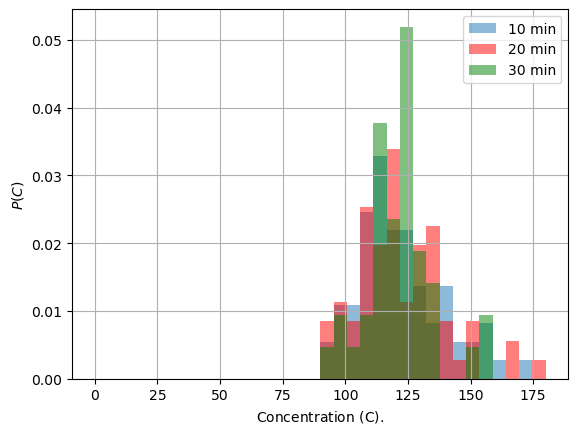

In [830]:
fig, ax = PyPlot.subplots(1,1);
time_bins = LinRange(0.0, 180.0, 35);
hist1_art, os = ax.hist(norm_gens_art[:,10], bins = time_bins, density = true, alpha = 0.5, label = "10 min"); 
hist2_art, os = ax.hist(norm_gens_art[:,20], color = "r", bins = time_bins, density = true, alpha = 0.5, label = "20 min"); 
hist3_art, os = ax.hist(norm_gens_art[:,30], color = "g", bins = time_bins, density = true, alpha = 0.5, label = "30 min"); 
ax.grid(true); ax.set_xlabel(L"Concentration (C)$.$"); ax.set_ylabel(L"$P(C)$"); ax.legend()
PyPlot.show()

In [831]:
@time print(hellinger(hist1, hist1_art), "\n", hellinger(hist2, hist2_art), "\n", hellinger(hist3, hist3_art), "\n")

0.332800869929837
0.41720377760413796
0.3369535990365266
  0.000112 seconds (105 allocations: 3.469 KiB)


Plot the histogram (appropriately chosen x axis) and store the bin values as from the PDF.

In [832]:
all_pts = vcat(filter(!isnan,vcat(conc_gens...)));
all_pts_SSA = vcat(filter(!isnan,vcat(expt_ssa_conc...)));

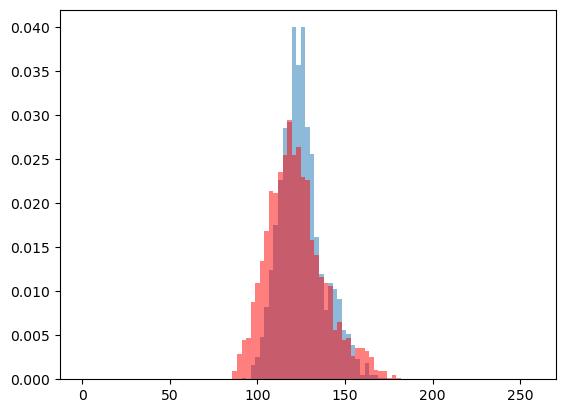

The HD between these two distributions is: 0.2099494415678632

In [833]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0.0, maximum(all_pts)*1.5, 100);
true_bin_vals, other_stuff = ax.hist(all_pts, bins = mod_bins, density = true, alpha = 0.5);
SSA_bin_vals, other_stuff = ax.hist(all_pts_SSA, bins = mod_bins, density = true, alpha = 0.5, color = "r");


print("The HD between these two distributions is: ",hellinger(true_bin_vals, SSA_bin_vals)) # check the sum of bins is 1.

true_bin_vals_form = convert(Array{Float64,2},transpose(true_bin_vals));

# Calculate $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ from Lsq on the mean for each generation

In [834]:
using LsqFit;

In [843]:
v0_n0_th[1][1][3]

0.025377210406455762

In [844]:
LinRange(1,length(expt_ssa_conc[1]), length(expt_ssa_conc[1]))

33-element LinRange{Float64}:
 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,…,27.0,28.0,29.0,30.0,31.0,32.0,33.0

In [845]:
comb_pars = [];
for i in 1:length(v0_n0_th[1])
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((10 .^ab[1]*v0^(10 .^ab[2]-1))/(10 .^ab[2]*th))*(exp.((10 .^ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t);
    ab0 = [5.0, 1.0];
    c_data = expt_ssa_conc[i];
    fit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars,fit)
end
comb_pars = convert(Array{Float64,2},transpose(hcat(comb_pars...)))

69×2 Array{Float64,2}:
 0.373835  2.85933
 3.25669   0.685554
 3.27239   1.43604
 8.86861   9.04218e-13
 3.0658    1.36962
 7.45301   1.77071e-13
 6.55634   2.14089e-15
 3.25771   0.980898
 6.75559   0.263179
 1.66685   1.31411
 1.46853   1.62508
 2.37139   1.14054
 2.61561   1.29142
 ⋮         
 7.40635   0.674531
 1.97566   1.47603
 1.95008   1.35163
 9.33442   1.74827e-14
 6.48635   2.27874e-12
 2.24709   1.60094
 2.41293   1.42211
 8.89133   7.14298e-14
 2.51418   1.26484
 2.40542   1.34287
 5.47783   0.487542
 6.42516   0.295871

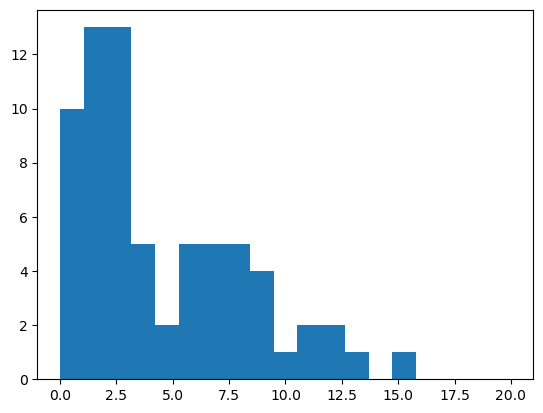

In [846]:
PyPlot.hist(comb_pars[:,1], bins = LinRange(0.0, 20, 20));

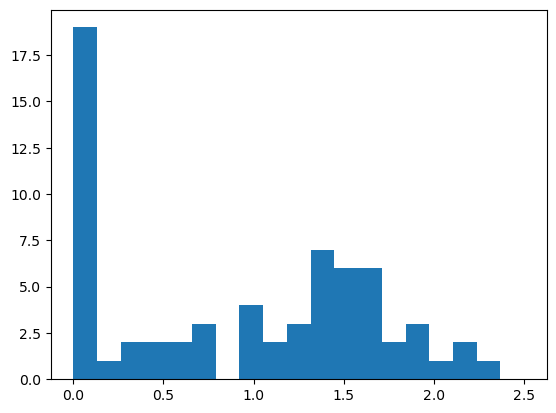

In [847]:
PyPlot.hist(comb_pars[:,2], bins = LinRange(0.0, 2.5, 20));

In [621]:
av_ab_0 = sum(comb_pars[:,1])/length(comb_pars[:,1]); av_ab_1 = sum(comb_pars[:,2])/length(comb_pars[:,2]);
print(av_ab_0, "\t", av_ab_1, "\t")

5.050522481369662	0.9126578259194723	

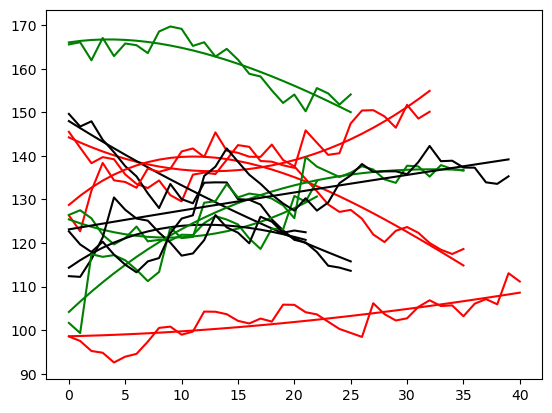

In [414]:
avg_traj = [];
for i in 1:10
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; #ab = [av_ab_0, av_ab_1];
    ab = comb_pars[i,:];
    traj = [((ab[1]*v0^(ab[2]-1))/(ab[2]*th))*(exp.((ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t) for t in 1:length(conc_gens_art[i])];
    push!(avg_traj,traj)
end

#print(avg_traj[1]);
colors = ["r","g","black","r","g","black","r","g","black"];
fig, ax = PyPlot.subplots(1,1);
for i in 1:9#length(conc_gens)
    ax.plot(conc_gens_art[i], color = colors[i])
    ax.plot(avg_traj[i], color = colors[i])
end
PyPlot.show()

# Inference set-up

## Transcription rate volume dependence

Now let's set up the tools needed to perform the inference of the parameters as we did in notebook 5. In this case the output will be the bin values for the histogram of the trajectory. Later we will specify the Hellinger distance measure in the SMC-ABC options.

In [39]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params::Array{Float64,1})
    lin_conc = Single_lin(lineage_data, var_params, lin_ic)
    return hcat(vcat(lin_conc...))
end

simulator_function_conc (generic function with 1 method)

Define function that takes in the 1-D array of un-separated generations and returns the separated 2-D array in terms of generations.

In [40]:
conc_gens = conc_sep_all_lins[1]; # take this for the data structure.
function make_2d(flat_arr::Array{Float64,1})
    # take lengths of each gen
    dims = [length(conc_gens[x]) for x in 1:length(conc_gens)];
    cum_dims = prepend!([sum(dims[1:y]) for y in 1:length(dims)],1);
    new_arr = [flat_arr[cum_dims[i]:cum_dims[i+1]] for i in 1:length(dims)];
    return new_arr
end

make_2d (generic function with 1 method)

Set-up the artificial SSA trajectory.

In [41]:
true_par

4-element Array{Float64,1}:
 0.025
 1.0
 0.5
 1.0e-6

In [42]:
art_data = simulator_function_conc(true_par);

In [76]:
function new_distance(flat_lin_1::Array{Float64,1}, flat_lin_2::Array{Float64,1})
    lin_1 = make_2d(flat_lin_1[:]); lin_2 = make_2d(flat_lin_2[:]);
    max_len = maximum([length(gen) for gen in lin_1]);
    lin_1_new = []; lin_2_new = []; # NaN padded lin arrays.
    
    for i in 1:length(lin_1) # add NaNs to lins
        gen_len = length(lin_1[i]); new_gen_1 = copy(lin_1[i]); new_gen_2 = copy(lin_2[i]);
        add_nans = [NaN for i in 1:(max_len - gen_len)]
        append!(new_gen_1, add_nans); append!(new_gen_2, add_nans); 
        push!(lin_1_new, new_gen_1); push!(lin_2_new, new_gen_2);
    end
    
    sq_lin_1 = convert(Array{Float64,2},transpose(hcat(lin_1_new...)));
    sq_lin_2 = convert(Array{Float64,2},transpose(hcat(lin_2_new...)));

    num_slices = 10;
    max_HD_time = round(Int64, 0.75*max_len);
    HD_times = [j*max_HD_time ÷ num_slices for j in 1:num_slices];
    
    all_pts_1 = vcat(lin_1...); 
    all_pts_2 = vcat(lin_2...);
    traj_bins = LinRange(0.0, maximum(all_pts_2)*1.5, 100);
    tdist_1 = normalize(fit(Histogram, all_pts_1, traj_bins), mode=:probability).weights;
    tdist_2 = normalize(fit(Histogram, all_pts_2, traj_bins), mode=:probability).weights;
    traj_HD = hellinger(tdist_1, tdist_2);
    
    time_bins = LinRange(0.0, maximum(all_pts_2)*1.5, 35);
    lin_1_dists = [normalize(fit(Histogram, filter(!isnan,sq_lin_1[:,HD_times[x]]), time_bins), mode=:probability).weights for x in 1:num_slices];
    lin_2_dists = [normalize(fit(Histogram, filter(!isnan,sq_lin_2[:,HD_times[x]]), time_bins), mode=:probability).weights for x in 1:num_slices];
    HD_slices = sum([hellinger(lin_1_dists[y], lin_2_dists[y]) for y in 1:num_slices]); # could do product??

    #return traj_HD*HD_slices
    return HD_slices
end

new_distance (generic function with 1 method)

In [77]:
sum([new_distance(vcat(simulator_function_conc(true_par)...),vcat(simulator_function_conc(true_par)...)) for i in 1:1000])/1000

2.825178284259246

┌ Info: GpABC rejection simulation. ϵ = 8.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 617/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 6.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 370/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 741/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 253/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 517/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:23

┌ Info: GpABC SMC simulation accepted 143/28000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 149/29000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 157/30000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 162/31000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 165/32000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 171/33000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 176/34000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 180/35000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 522/92000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 530/93000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 537/94000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 543/95000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 552/96000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 555/97000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 561/98000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 567/99000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 265/54000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 273/55000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 279/56000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 283/57000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 285/58000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 287/59000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 292/60000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 298/61000 particles.
└ @ GpABC /home/s1402978

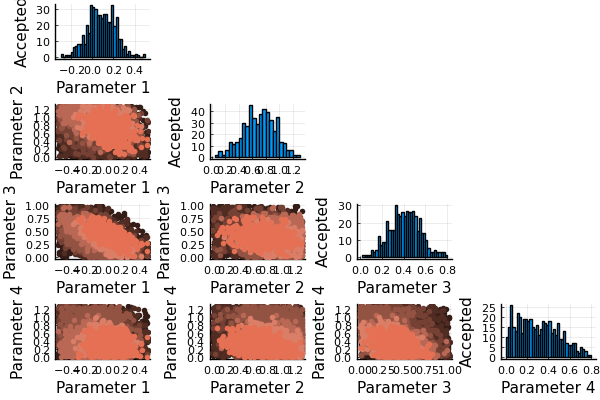

In [125]:
n_particles = 1000;
#threshold_schedule = [2.5, 1.25, 0.75, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.12];
threshold_schedule = [8.0, 6.0, 5.0, 4.0, 3.5, 3.0, 2.8];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(art_data,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

In [126]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 0.08381986243355494
 0.7113090412085858
 0.41500935300174635
 0.28857862058932127

In [127]:
true_par

4-element Array{Float64,1}:
 0.025
 1.0
 0.5
 1.0e-6

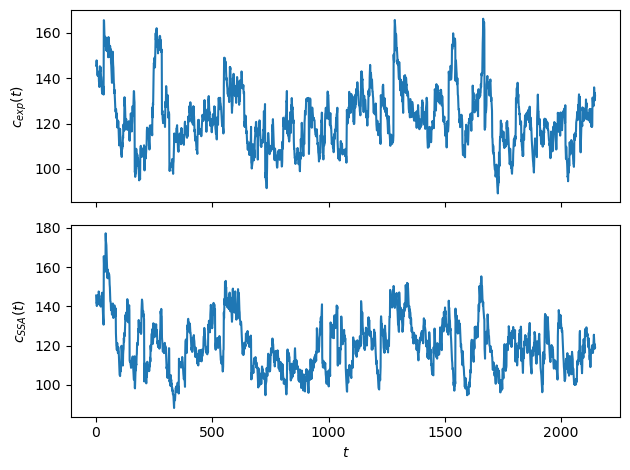

  0.002380 seconds (6.37 k allocations: 665.266 KiB)


In [128]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(art_data...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

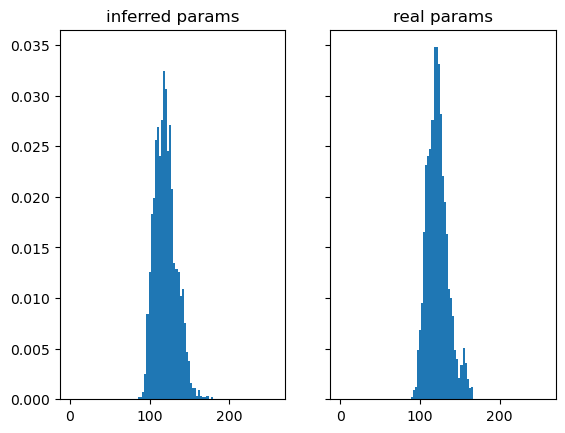

Hellinger distance between these is: 0.11540830846797472

In [129]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

# Run them again!

┌ Info: GpABC rejection simulation. ϵ = 8.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 637/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 6.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 381/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 747/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 254/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 528/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:23

┌ Info: GpABC SMC simulation accepted 46/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 51/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 66/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 75/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 88/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 100/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 114/10000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 128/11000 particles.
└ @ GpABC /home/s1402978/.julia/pac

┌ Info: GpABC SMC simulation accepted 787/68000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 795/69000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 810/70000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 823/71000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 840/72000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 855/73000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 868/74000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 877/75000 particles.
└ @ GpABC /home/s1402978

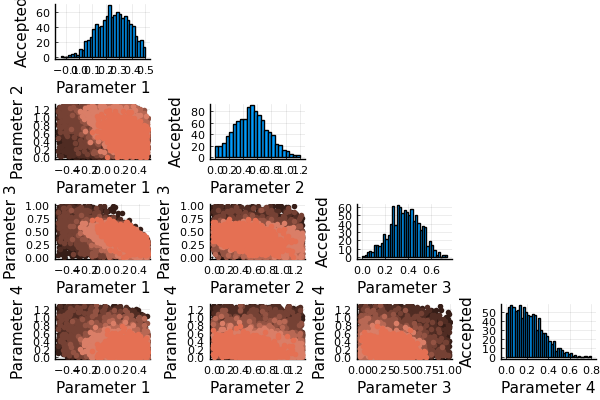

In [130]:
n_particles = 1000;
#threshold_schedule = [2.5, 1.25, 0.75, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.12];
threshold_schedule = [8.0, 6.0, 5.0, 4.0, 3.5, 3.0, 2.8];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(art_data,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors=population_colors)

In [131]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 0.26014026720659267
 0.5070278440936353
 0.3693986567011939
 0.18871986309620298

In [132]:
true_par

4-element Array{Float64,1}:
 0.025
 1.0
 0.5
 1.0e-6

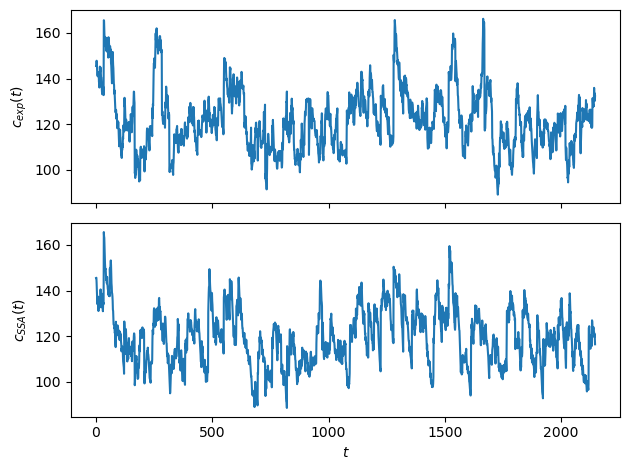

  0.002669 seconds (7.34 k allocations: 756.297 KiB)


In [133]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_2, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(art_data...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

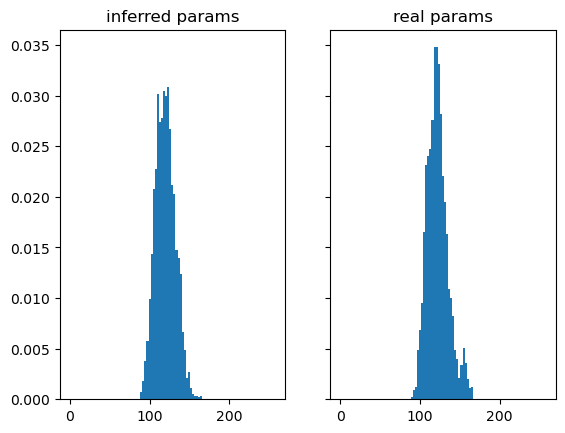

Hellinger distance between these is: 0.11124467932187886

In [134]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

┌ Info: GpABC rejection simulation. ϵ = 8.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 633/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 6.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 403/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 761/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 270/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 527/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:23

┌ Info: GpABC SMC simulation accepted 246/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 259/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 275/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 299/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 321/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 338/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 354/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 367/22000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 66/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 73/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 75/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 78/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 83/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 87/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 90/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 94/26000 particles.
└ @ GpABC /home/s1402978/.julia/

┌ Info: GpABC SMC simulation accepted 321/83000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 324/84000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 328/85000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 330/86000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 334/87000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 338/88000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 340/89000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 346/90000 particles.
└ @ GpABC /home/s1402978

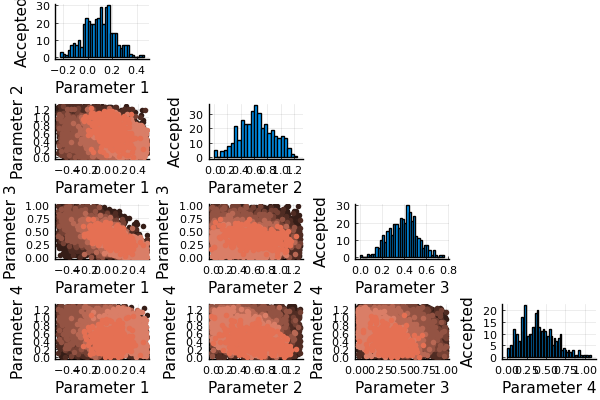

In [135]:
n_particles = 1000;
#threshold_schedule = [2.5, 1.25, 0.75, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.12];
threshold_schedule = [8.0, 6.0, 5.0, 4.0, 3.5, 3.0, 2.8];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_3 = SimulatedABCSMC(art_data,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935"]#,"#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_3, population_colors=population_colors)

In [136]:
pars_conc_3 = [median(sim_abcsmc_res_conc_3.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 0.09669531906127728
 0.6319770873480753
 0.3940352328262167
 0.3816452994374113

In [137]:
true_par

4-element Array{Float64,1}:
 0.025
 1.0
 0.5
 1.0e-6

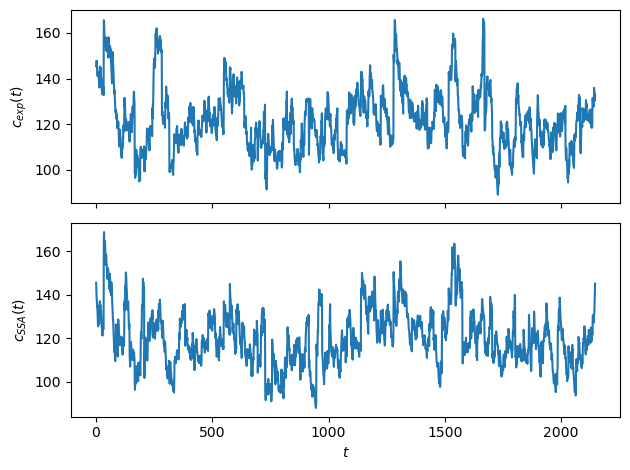

  0.001991 seconds (6.04 k allocations: 634.047 KiB)


In [138]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_3, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(art_data...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

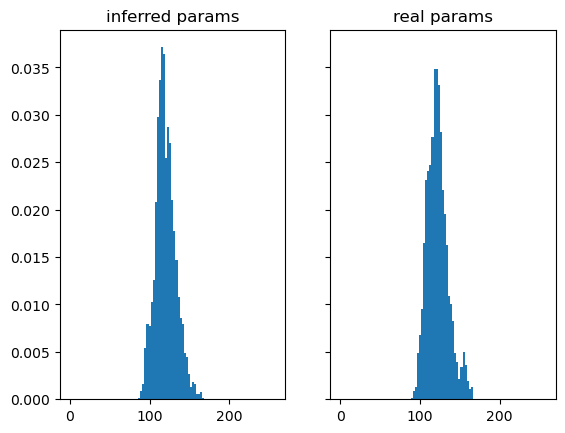

Hellinger distance between these is: 0.10249545645772905

In [139]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

## Burst size volume dependence

Set-up the artificial SSA trajectory.

In [140]:
true_par_2 = [0.025, 1E-6, 0.5, 1.0];

In [141]:
art_data_2 = simulator_function_conc(true_par_2);

In [142]:
sum([new_distance(vcat(simulator_function_conc(true_par_2)...),vcat(simulator_function_conc(true_par_2)...)) for i in 1:1000])/1000

3.19416856536747

┌ Info: GpABC rejection simulation. ϵ = 8.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 685/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 6.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 427/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 852/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 337/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 697/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:23

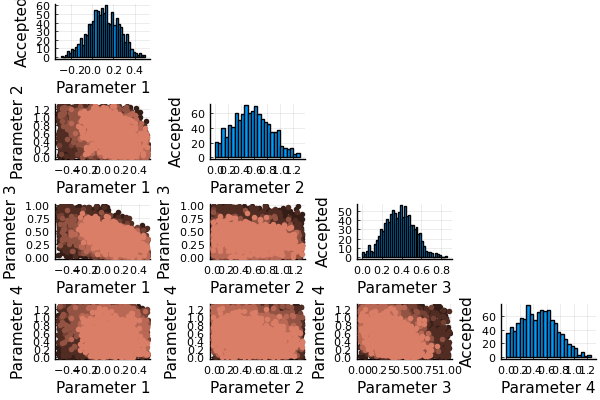

In [143]:
n_particles = 1000;
#threshold_schedule_b = [2.5, 1.25, 0.75, 0.5, 0.4, 0.3, 0.215];
threshold_schedule_b = [8.0, 6.0, 5.0, 4.0, 3.5, 3.1];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_1b = SimulatedABCSMC(art_data_2,
    simulator_function_conc,
    priors,
    threshold_schedule_b,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1b, population_colors=population_colors)

In [144]:
pars_conc_1b = [median(sim_abcsmc_res_conc_1b.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 0.10661933607602511
 0.5577053995886646
 0.37546906099951716
 0.4771543153787624

In [145]:
true_par_2

4-element Array{Float64,1}:
 0.025
 1.0e-6
 0.5
 1.0

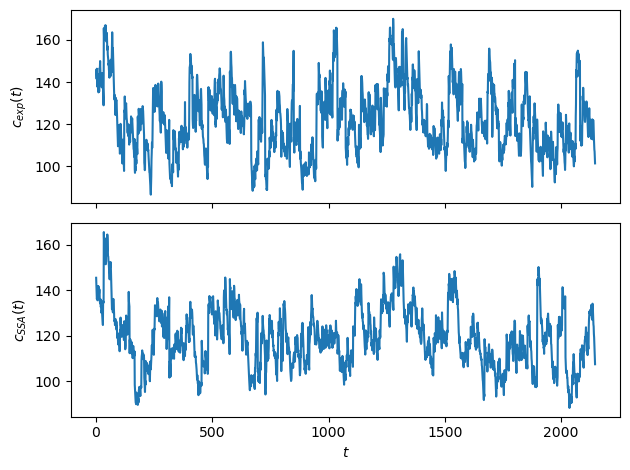

  0.002054 seconds (5.63 k allocations: 595.609 KiB)


In [146]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1b, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(art_data_2...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

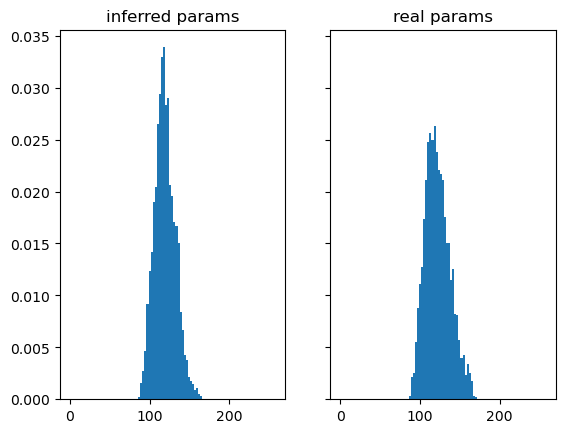

Hellinger distance between these is: 0.11202077792148045

In [147]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

# Run them again!

┌ Info: GpABC rejection simulation. ϵ = 8.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 689/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 6.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 386/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 800/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 314/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 680/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:23

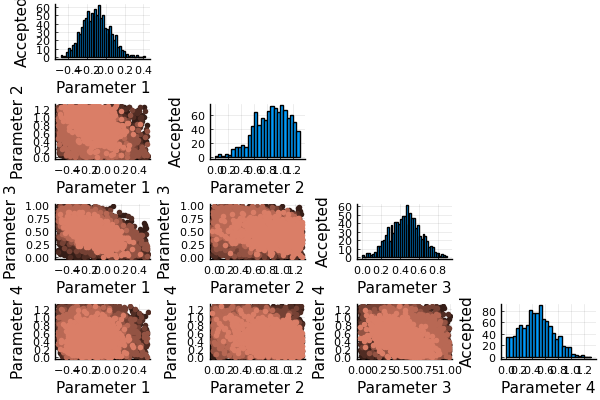

In [148]:
n_particles = 1000;
#threshold_schedule_b = [2.5, 1.25, 0.75, 0.5, 0.4, 0.3, 0.215];
threshold_schedule_b = [8.0, 6.0, 5.0, 4.0, 3.5, 3.1];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_2b = SimulatedABCSMC(art_data_2,
    simulator_function_conc,
    priors,
    threshold_schedule_b,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2b, population_colors=population_colors)

In [149]:
pars_conc_2b = [median(sim_abcsmc_res_conc_2b.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 -0.10663575983225942
  0.8843374585349915
  0.4560645961328331
  0.4643700074257751

In [150]:
true_par_2

4-element Array{Float64,1}:
 0.025
 1.0e-6
 0.5
 1.0

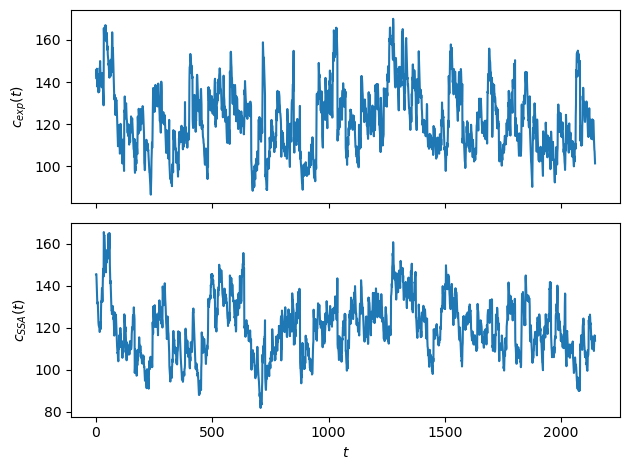

  0.001843 seconds (5.09 k allocations: 545.359 KiB)


In [151]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_2b, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(art_data_2...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

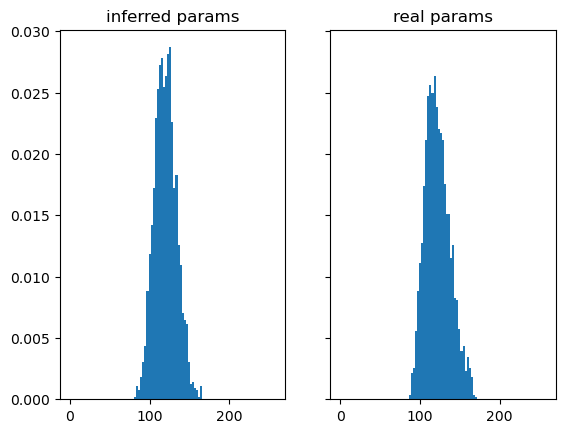

Hellinger distance between these is: 0.10915561337332473

In [152]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

┌ Info: GpABC rejection simulation. ϵ = 8.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 678/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 6.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 430/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 851/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 349/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 688/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:23

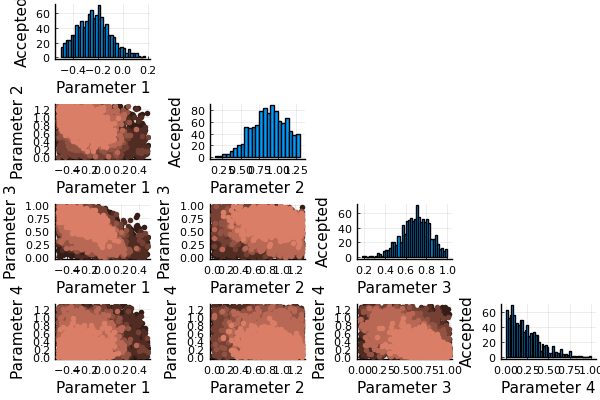

In [153]:
n_particles = 1000;
#threshold_schedule_b = [2.5, 1.25, 0.75, 0.5, 0.4, 0.3, 0.215];
threshold_schedule_b = [8.0, 6.0, 5.0, 4.0, 3.5, 3.1];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_3b = SimulatedABCSMC(art_data_2,
    simulator_function_conc,
    priors,
    threshold_schedule_b,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935"]#,"#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_3b, population_colors=population_colors)

In [156]:
pars_conc_3b = [median(sim_abcsmc_res_conc_3b.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 -0.18913825158430353
  0.9805889223676487
  0.4524502841494202
  0.53769571899951

In [155]:
true_par_2

4-element Array{Float64,1}:
 0.025
 1.0e-6
 0.5
 1.0